I want to share what I learned and practiced from [SRK](https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue) and Andrew Lukyanenko[](https://www.kaggle.com/artgor/fork-of-eda-on-basic-data-and-lgb-in-progress) 's kernel.
Thanks for their open kernel for study and let me start the practice.

In [4]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

In [5]:
import numpy as np 
import pandas as pd 
import json
import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error

Let's see the train data. There are JSON format like device, hits, etc.

In [6]:
train1=pd.read_csv("../input/train_v2.csv",nrows=200)
train1.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


[Someone](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields) opened his kernel to deal with parsing JSON as below.

In [7]:
# https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [9]:
%%time
train = load_df("../input/train_v2.csv",nrows=20000)
test = load_df("../input/test_v2.csv")

Loaded train_v2.csv. Shape: (20000, 59)
Loaded test_v2.csv. Shape: (401589, 59)
CPU times: user 2min 10s, sys: 11.8 s, total: 2min 22s
Wall time: 2min 24s


After parsing, data looks as below.

In [10]:
train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not ava

Adjust NA of 'trafficSource.adwordsClickInfo.isVideoAd' to True
Adjust NA of 'trafficSource.isTrueDirect' to False
Then set the date format as yyyy-mm-dd

In [11]:
# some data processing
train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
test['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
train['trafficSource.isTrueDirect'].fillna(False, inplace=True)
test['trafficSource.isTrueDirect'].fillna(False, inplace=True)

train['date'] = pd.to_datetime(train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
test['date'] = pd.to_datetime(test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

In [12]:
train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,True,NaN,NaN,(not set),False,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,True,NaN,NaN,(not set),False,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable

**Data Exploration**

At first drop some useless columns that has only one variables like 'socialEngagementType'
As below, the number of unique variable in 'socialEngagementType' is 1.

In [21]:
train['socialEngagementType'].nunique(dropna=False)

1

In [22]:
cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False) == 1]
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop([col for col in cols_to_drop if col in test.columns], axis=1, inplace=True)

print(f'Dropped {len(cols_to_drop)} columns.')

Dropped 19 columns.


Change some variables into float data

In [23]:
for col in ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']:
    train[col] = train[col].astype(float)

Drop some features

In [24]:
train.drop(['customDimensions', 'hits', 'trafficSource.referralPath', 'trafficSource.source', 'totals.totalTransactionRevenue'], axis=1, inplace=True)
test.drop(['customDimensions', 'hits', 'trafficSource.referralPath', 'trafficSource.source', 'totals.totalTransactionRevenue'], axis=1, inplace=True)

This data seems moe simple and looks better.

In [25]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1.0,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1.0,1,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,water bottle,organic
1,Referral,2017-10-16,8934116514970143966,1508176307,6.0,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2.0,NaN,2.0,2,28,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,NaN,referral
2,Direct,2017-10-16,7992466427990357681,1508201613,1.0,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2.0,1,2.0,1,38,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),True,NaN,(none)
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1.0,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2.0,1,2.0,1,1,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,(not provided),organic
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1.0,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2.0,1,2.0,1,52,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,(not provided),organic


Let's see the revenue of each visitor.

In [33]:
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
gdf

,fullVisitorId,totals.transactionRevenue
0,0000245437374675368,0.0
1,0000593255797039768,0.0
2,0000750929315523353,0.0
3,0001191766179392657,0.0
4,0003631840334189025,0.0
5,0004374401845204055,0.0
6,0004803397127474847,0.0
7,0005096736076850458,0.0
8,0005694527603480368,0.0
9,0006008740756625566,0.0


Make a graph with the table above, sorting with logarithm of revenue.
The graph shows very low percent of visitors make almost revenue.

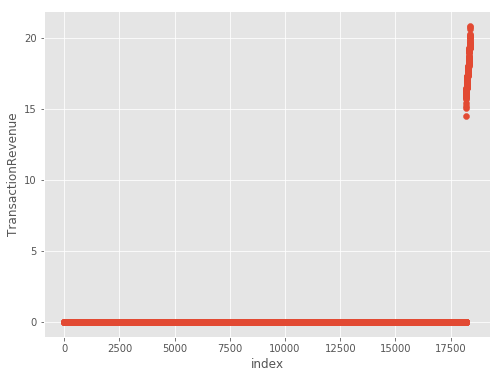

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [40]:
pd.notnull(train["totals.transactionRevenue"])

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
19970    False
19971    False
19972    False
19973    False
19974    False
19975    False
19976    False
19977    False
19978    False
19979    False
19980    False
19981    False
19982    False
19983    False
19984    False
19985    False
19986    False
19987    False
19988    False
19989    False
19990    False
19991    False
19992    False
19993    False
19994    False
19995    False
19996    False
19997    False
19998    False
19999    False
Name: totals.transactionRevenue, Length: 20000, dtype: bool

After calculating the ratio of real users, it shows only 1.03% of users make revenue through transaction

In [50]:
print("Number of unique customers with non-zero revenue : ", (gdf["totals.transactionRevenue"]>0).sum(), "and the ratio is : ", round(100*(gdf["totals.transactionRevenue"]>0).sum() / gdf.shape[0],2),"%")

Number of unique customers with non-zero revenue :  189 and the ratio is :  1.03 %


Let's look at how many users visit how many times.
It shows about 92% are unique users and only 8% users are revisited.

In [54]:
print("Number of unique visitors in train set : ",train.fullVisitorId.nunique(), " the ratio is : ",round(100*train.fullVisitorId.nunique()/train.shape[0],2),"%")

Number of unique visitors in train set :  18384  the ratio is :  91.92 %


Let's explore data by device.
For example, groupping the train data by "browser" with size, count and mean, then the table is as below.

In [79]:
train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])

,size,count,mean
device.browser,,,
ADM,1,0,NaN
Amazon Silk,20,0,NaN
Android Browser,11,0,NaN
Android Webview,300,0,NaN
BlackBerry,4,0,NaN
Chrome,13978,171,1.167348e+08
Coc Coc,14,0,NaN
Edge,267,3,1.348333e+07
Firefox,829,2,1.349000e+07


Using same logic to browser, device and OS, draw graphs as below.

In [69]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



Below graphs show the continent dependancy.

In [86]:
# Continent
cnt_srs = train.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Creating subplots
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)

fig['layout'].update(height=500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



Until now is the part of exploratory data analysis for GA revenue prediction, which I learned from [SRK](https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue) and Andrew Lukyanenko[](https://www.kaggle.com/artgor/fork-of-eda-on-basic-data-and-lgb-in-progress) 's kernel